In [1]:
## Importing all the required header files

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub 
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
from IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.9.1
Hub version:  0.12.0


You should consider upgrading via the 'C:\Users\shrns\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
## Reading the data

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                compression='zip',
                low_memory=False)

df.shape

(1306122, 3)

<AxesSubplot:title={'center':'Target Distribution'}, ylabel='Frequency'>

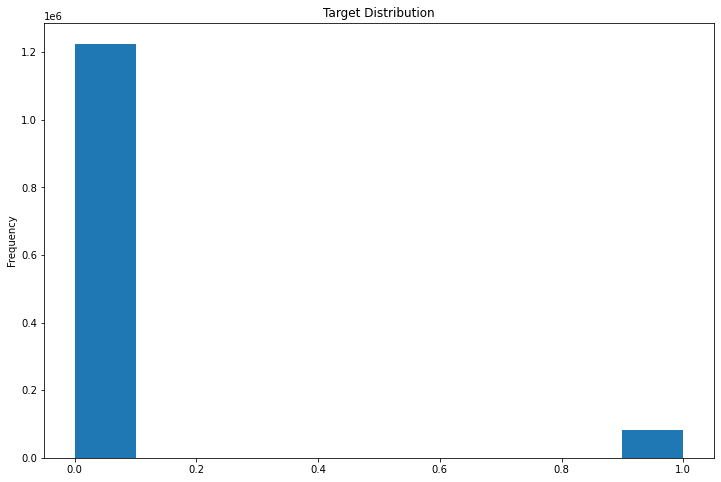

In [3]:
df['target'].plot(kind='hist', title='Target Distribution')

In [4]:
from sklearn.model_selection import train_test_split

In [7]:
##Splitting the training data and the validation data
##We are taking 10000-15000 values of data for training and 1000-1500 values of data for validating 

train_df, remaining = train_test_split(df, random_state=20, train_size=0.01, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=20, train_size=0.001, stratify=remaining.target.values)

train_df.shape, valid_df.shape

((13061, 3), (1293, 3))

In [8]:
train_df.question_text.head(20).values

array(['Do you prefer long-haired or short-haired cats?',
       'What are the essential life skill for a six-year old boy?',
       'How did you manage both your love and career?',
       'Are you a coin collector? Can you show your collection here?',
       'What are the key takeaways of the book, Thanks for the Feedback?',
       "If there are 90 million Phantom drones on eBay, why can't I win one for $0.99 instead of $2,000?",
       'How do I find a basketball agent to see my great skills as a basketball player?',
       'What is the best place for street food in Shillong?',
       'Where can I get cheap trendy wholesale clothing?',
       'Why do you see pink when you walk inside, from a snowy day outside?',
       'What if Britain in 1913 gave representation in parliamant to all parts of the British Empire and their subjects, including women of the empire?',
       "What is the value of 'a' if: 2*sin(a) =sin (120-a)?",
       "What's the best way to get back at a man who has tre

In [71]:
## Models to be used:
model_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
# https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1
# https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1
# https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1
# https://tfhub.dev/google/universal-sentence-encoder/4
# https://tfhub.dev/google/universal-sentence-encoder-large/5

In [76]:
## Building and Training the model

def train_and_evaluate_model(model_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(model_url,input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

    model = tf.keras.models.Sequential([
            hub_layer,
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.summary()
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=tf.losses.BinaryCrossentropy(),
                 metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])
    
    history = model.fit(train_df['question_text'], train_df['target'],
                        epochs=100,
                        batch_size=32,
                        validation_data=(valid_df['question_text'], valid_df['target']),
                        callbacks=[tfdocs.modeling.EpochDots(),
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                  tf.keras.callbacks.TensorBoard(logdir/name)],
                        verbose=0)
    return history

In [42]:
histories = {}

In [72]:
histories['universal-sentence-encoder-large']=train_and_evaluate_model(model_url, embed_size=512, name='universal-sentence-encoder-large')

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_17 (KerasLayer)  (None, 512)              147354880 
                                                                 
 dense_51 (Dense)            (None, 256)               131328    
                                                                 
 dense_52 (Dense)            (None, 64)                16448     
                                                                 
 dense_53 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.9277,  loss:0.3192,  val_accuracy:0.9381,  val_loss:0.1731,  
......

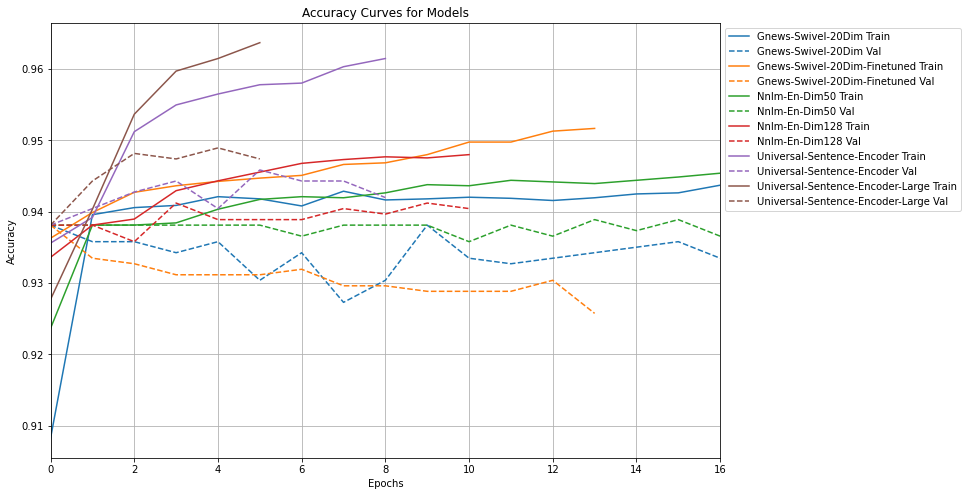

In [73]:
plt.rcParams['figure.figsize']=(12,8)
plotter=tfdocs.plots.HistoryPlotter(metric='accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

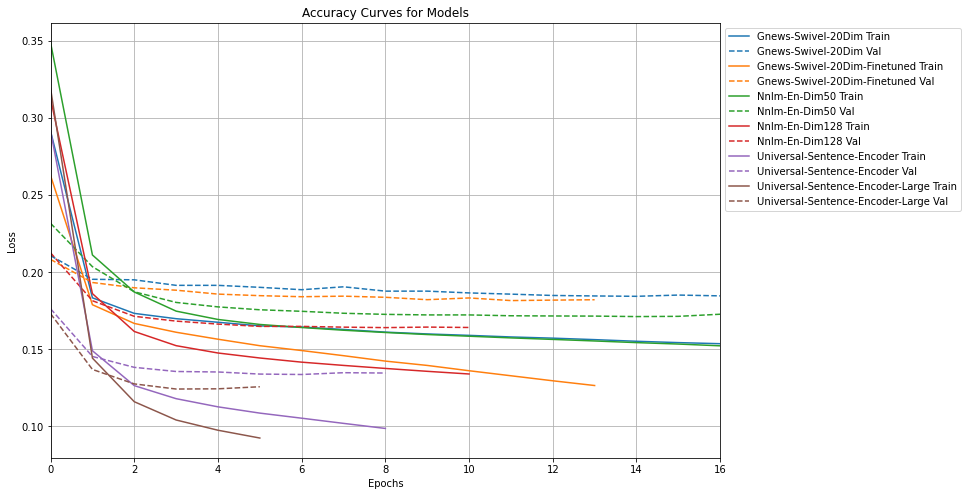

In [74]:
plotter=tfdocs.plots.HistoryPlotter(metric='loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()